# Pendulum-v0环境

    使用Policy-Based方法比如DDPG等实现Pendulum-v0环境

![img](https://datawhalechina.github.io/easy-rl/chapter12/img/image-20200820174814084.png)

    钟摆以随机位置开始，目标是将其摆动，使其保持向上直立。动作空间是连续的，值的区间为[-2,2]。每个step给的reward最低为-16.27，最高为0。

In [4]:
# 环境建立如下：

import gym
import turtle
import numpy as np

env = gym.make('Pendulum-v1') 
env.seed(1) # 设置env随机种子
n_states = env.observation_space.shape[0] # 获取总的状态数

print(n_states)

3


# 建立Model

In [5]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [6]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity # 经验回放的容量
        self.buffer = [] # 缓冲区
        self.position = 0 
    
    def push(self, state, action, reward, next_state, done):
        ''' 缓冲区是一个队列，容量超出时去掉开始存入的转移(transition)
        '''
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity 
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size) # 随机采出小批量转移
        state, action, reward, next_state, done =  zip(*batch) # 解压成状态，动作等
        return state, action, reward, next_state, done
    
    def __len__(self):
        ''' 返回当前存储的量
        '''
        return len(self.buffer)
class Actor(nn.Module):
    def __init__(self, n_states, n_actions, hidden_dim, init_w=3e-3):
        super(Actor, self).__init__()  
        self.linear1 = nn.Linear(n_states, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, n_actions)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = torch.tanh(self.linear3(x))
        return x
class Critic(nn.Module):
    def __init__(self, n_states, n_actions, hidden_dim, init_w=3e-3):
        super(Critic, self).__init__()
        
        self.linear1 = nn.Linear(n_states + n_actions, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        # 随机初始化为较小的值
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        # 按维数1拼接
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
class DDPG:
    def __init__(self, n_states, n_actions, cfg):
        self.device = torch.device(cfg.device)
        self.critic = Critic(n_states, n_actions, cfg.hidden_dim).to(self.device)
        self.actor = Actor(n_states, n_actions, cfg.hidden_dim).to(self.device)
        self.target_critic = Critic(n_states, n_actions, cfg.hidden_dim).to(self.device)
        self.target_actor = Actor(n_states, n_actions, cfg.hidden_dim).to(self.device)

        # 复制参数到目标网络
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data)

        self.critic_optimizer = optim.Adam(
            self.critic.parameters(),  lr=cfg.critic_lr)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=cfg.actor_lr)
        self.memory = ReplayBuffer(cfg.memory_capacity)
        self.batch_size = cfg.batch_size
        self.soft_tau = cfg.soft_tau # 软更新参数
        self.gamma = cfg.gamma

    def choose_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        action = self.actor(state)
        return action.detach().cpu().numpy()[0, 0]

    def update(self):
        if len(self.memory) < self.batch_size: # 当 memory 中不满足一个批量时，不更新策略
            return
        # 从经验回放中(replay memory)中随机采样一个批量的转移(transition)
        state, action, reward, next_state, done = self.memory.sample(self.batch_size)
        # 转变为张量
        state = torch.FloatTensor(np.array(state)).to(self.device)
        next_state = torch.FloatTensor(np.array(next_state)).to(self.device)
        action = torch.FloatTensor(np.array(action)).to(self.device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(self.device)
        done = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(self.device)
        
        policy_loss = self.critic(state, self.actor(state))
        policy_loss = -policy_loss.mean()
        next_action = self.target_actor(next_state)
        target_value = self.target_critic(next_state, next_action.detach())
        expected_value = reward + (1.0 - done) * self.gamma * target_value
        expected_value = torch.clamp(expected_value, -np.inf, np.inf)

        value = self.critic(state, action)
        value_loss = nn.MSELoss()(value, expected_value.detach())
        
        self.actor_optimizer.zero_grad()
        policy_loss.backward()
        self.actor_optimizer.step()
        self.critic_optimizer.zero_grad()
        value_loss.backward()
        self.critic_optimizer.step()
        # 软更新
        for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.soft_tau) +
                param.data * self.soft_tau
            )
        for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - self.soft_tau) +
                param.data * self.soft_tau
            )
    def save(self,path):
        torch.save(self.actor.state_dict(), path+'checkpoint.pt')

    def load(self,path):
        self.actor.load_state_dict(torch.load(path+'checkpoint.pt')) 

# 建立环境

In [7]:
import gym
import numpy as np

In [8]:

class NormalizedActions(gym.ActionWrapper):
    ''' 将action范围重定在[0.1]之间
    '''
    def action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        action = low_bound + (action + 1.0) * 0.5 * (upper_bound - low_bound)
        action = np.clip(action, low_bound, upper_bound)
        return action

    def reverse_action(self, action):
        low_bound   = self.action_space.low
        upper_bound = self.action_space.high
        action = 2 * (action - low_bound) / (upper_bound - low_bound) - 1
        action = np.clip(action, low_bound, upper_bound)
        return action

class OUNoise(object):
    '''Ornstein–Uhlenbeck噪声
    '''
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu # OU噪声的参数
        self.theta        = theta # OU噪声的参数
        self.sigma        = max_sigma # OU噪声的参数
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.n_actions   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()
    def reset(self):
        self.obs = np.ones(self.n_actions) * self.mu
    def evolve_obs(self):
        x  = self.obs
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.n_actions)
        self.obs = x + dx
        return self.obs
    def get_action(self, action, t=0):
        ou_obs = self.evolve_obs()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period) # sigma会逐渐衰减
        return np.clip(action + ou_obs, self.low, self.high) # 动作加上噪声后进行剪切

# 开始训练 & 测试

In [10]:
import sys,os
__file__ = "/Users/xiejianghuangchao/Downloads/XXX.ipynb"
curr_path = os.path.dirname(os.path.abspath(__file__))  # current path
parent_path = os.path.dirname(curr_path)  # parent path
#sys.path.append(parent_path)  # add to system path

import datetime
import gym
import torch
import argparse

#from env import NormalizedActions,OUNoise
#from ddpg import DDPG
from common.utils import save_results,make_dir
from common.utils import plot_rewards,save_args

curr_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") # 获取当前时间

print(curr_path, curr_time)

/Users/xiejianghuangchao/Downloads 2022-07-26 15:20:02


## 配置超参数

In [15]:

def get_args():
    """ Hyperparameters
    """
    curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # Obtain current time
    parser = argparse.ArgumentParser(description="hyperparameters")      
    parser.add_argument('--algo_name',default='DDPG',type=str,help="name of algorithm")
    parser.add_argument('--env_name',default='Pendulum-v1',type=str,help="name of environment")
    parser.add_argument('--train_eps',default=300,type=int,help="episodes of training")
    parser.add_argument('--test_eps',default=20,type=int,help="episodes of testing")
    parser.add_argument('--gamma',default=0.99,type=float,help="discounted factor")
    parser.add_argument('--critic_lr',default=1e-3,type=float,help="learning rate of critic")
    parser.add_argument('--actor_lr',default=1e-4,type=float,help="learning rate of actor")
    parser.add_argument('--memory_capacity',default=8000,type=int,help="memory capacity")
    parser.add_argument('--batch_size',default=128,type=int)
    parser.add_argument('--target_update',default=2,type=int)
    parser.add_argument('--soft_tau',default=1e-2,type=float)
    parser.add_argument('--hidden_dim',default=256,type=int)
    parser.add_argument('--device',default='cpu',type=str,help="cpu or cuda") 
    parser.add_argument('--result_path',default=curr_path + "/outputs/" + parser.parse_args().env_name + \
            '/' + curr_time + '/results/' )
    parser.add_argument('--model_path',default=curr_path + "/outputs/" + parser.parse_args().env_name + \
            '/' + curr_time + '/models/' ) # path to save models
    parser.add_argument('--save_fig',default=True,type=bool,help="if save figure or not")   
    args = parser.parse_args()                           
    return args

def env_agent_config(cfg,seed=1):
    env = NormalizedActions(gym.make(cfg.env_name)) # 装饰action噪声
    env.seed(seed) # 随机种子
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.shape[0]
    agent = DDPG(n_states,n_actions,cfg)
    return env,agent


In [16]:
class Config:
    """ Hyperparameters
    """
    curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # Obtain current time
    algo_name='DDPG'
    env_name='Pendulum-v1'
    train_eps=300
    test_eps=20
    gamma=0.99
    critic_lr=1e-3
    actor_lr=1e-4
    memory_capacity=8000
    batch_size=128
    target_update=2
    soft_tau=1e-2
    
    hidden_dim=256
    device='cpu'
    result_path=curr_path + "/outputs/" + env_name + '/' + curr_time + '/results/'
    model_path=curr_path + "/outputs/" + env_name + '/' + curr_time + '/models/' # path to save models
    save_fig=True                   
    
a = Config()

## 训练 & 测试Func

In [17]:
def train(cfg, env, agent):
    print('Start training!')
    print(f'Env:{cfg.env_name}, Algorithm:{cfg.algo_name}, Device:{cfg.device}')
    ou_noise = OUNoise(env.action_space)  # noise of action
    rewards = [] # 记录所有回合的奖励
    ma_rewards = []  # 记录所有回合的滑动平均奖励
    for i_ep in range(cfg.train_eps):
        state = env.reset()
        ou_noise.reset()
        done = False
        ep_reward = 0
        i_step = 0
        while not done:
            i_step += 1
            action = agent.choose_action(state)
            action = ou_noise.get_action(action, i_step) 
            next_state, reward, done, _ = env.step(action)
            ep_reward += reward
            agent.memory.push(state, action, reward, next_state, done)
            agent.update()
            state = next_state
        if (i_ep+1)%10 == 0:
            print(f'Env:{i_ep+1}/{cfg.train_eps}, Reward:{ep_reward:.2f}')
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(0.9*ma_rewards[-1]+0.1*ep_reward)
        else:
            ma_rewards.append(ep_reward)
    print('Finish training!')
    return {'rewards':rewards,'ma_rewards':ma_rewards}

def test(cfg, env, agent):
    print('Start testing')
    print(f'Env:{cfg.env_name}, Algorithm:{cfg.algo_name}, Device:{cfg.device}')
    rewards = [] # 记录所有回合的奖励
    ma_rewards = []  # 记录所有回合的滑动平均奖励
    for i_ep in range(cfg.test_eps):
        state = env.reset() 
        done = False
        ep_reward = 0
        i_step = 0
        while not done:
            i_step += 1
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            ep_reward += reward
            state = next_state
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(0.9*ma_rewards[-1]+0.1*ep_reward)
        else:
            ma_rewards.append(ep_reward)
        print(f"Epside:{i_ep+1}/{cfg.test_eps}, Reward:{ep_reward:.1f}")
    print('Finish testing!')
    return {'rewards':rewards,'ma_rewards':ma_rewards}


## RUN

Start training!
Env:Pendulum-v1, Algorithm:DDPG, Device:cpu
Env:10/300, Reward:-515.42
Env:20/300, Reward:-259.51
Env:30/300, Reward:-237.96
Env:40/300, Reward:-479.19
Env:50/300, Reward:-382.05
Env:60/300, Reward:-498.14
Env:70/300, Reward:-504.65
Env:80/300, Reward:-254.29
Env:90/300, Reward:-627.44
Env:100/300, Reward:-610.84
Env:110/300, Reward:-392.74
Env:120/300, Reward:-804.61
Env:130/300, Reward:-622.48
Env:140/300, Reward:-598.58
Env:150/300, Reward:-708.14
Env:160/300, Reward:-485.28
Env:170/300, Reward:-372.57
Env:180/300, Reward:-376.35
Env:190/300, Reward:-619.23
Env:200/300, Reward:-616.13
Env:210/300, Reward:-625.11
Env:220/300, Reward:-736.87
Env:230/300, Reward:-613.99
Env:240/300, Reward:-615.96
Env:250/300, Reward:-488.66
Env:260/300, Reward:-126.73
Env:270/300, Reward:-741.27
Env:280/300, Reward:-363.56
Env:290/300, Reward:-863.68
Env:300/300, Reward:-495.24
Finish training!
Parameters saved!


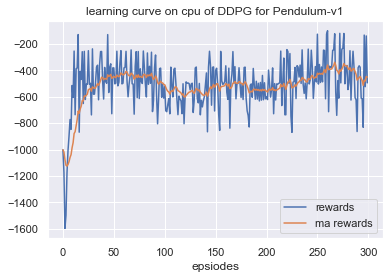

Start testing
Env:Pendulum-v1, Algorithm:DDPG, Device:cpu
Epside:1/20, Reward:-248.2
Epside:2/20, Reward:-126.5
Epside:3/20, Reward:-7.1
Epside:4/20, Reward:-130.1
Epside:5/20, Reward:-8.2
Epside:6/20, Reward:-124.8
Epside:7/20, Reward:-134.3
Epside:8/20, Reward:-119.5
Epside:9/20, Reward:-254.2
Epside:10/20, Reward:-256.1
Epside:11/20, Reward:-124.4
Epside:12/20, Reward:-127.7
Epside:13/20, Reward:-7.1
Epside:14/20, Reward:-124.3
Epside:15/20, Reward:-127.6
Epside:16/20, Reward:-122.5
Epside:17/20, Reward:-242.5
Epside:18/20, Reward:-122.1
Epside:19/20, Reward:-248.0
Epside:20/20, Reward:-130.5
Finish testing!


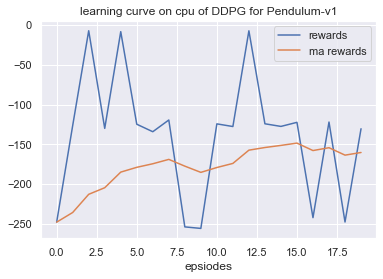

In [19]:
if __name__ == "__main__":
    cfg = Config() #get_args()
    # training
    env,agent = env_agent_config(cfg,seed=1)
    res_dic = train(cfg, env, agent)
    make_dir(cfg.result_path, cfg.model_path)
    save_args(cfg)
    agent.save(path=cfg.model_path)
    #save_results(res_dic, tag='train',
    #             path=cfg.result_path)  
    plot_rewards(res_dic['rewards'], res_dic['ma_rewards'], cfg, tag="train")  
    # testing
    env,agent = env_agent_config(cfg,seed=10)
    agent.load(path=cfg.model_path)
    res_dic = test(cfg,env,agent)
    #save_results(res_dic, tag='test',
    #             path=cfg.result_path)  
    plot_rewards(res_dic['rewards'], res_dic['ma_rewards'], cfg, tag="test")   

In [ ]:
""" 训练并绘制reward以及滑动平均后的reward随episode的变化曲线图并记录超参数写成报告 """

In [ ]:
rewards = [] # 记录总的rewards
moving_average_rewards = [] # 记录总的经滑动平均处理后的rewards
ep_steps = []
for i_episode in range(1, cfg.max_episodes+1): # cfg.max_episodes为最大训练的episode数
    state = env.reset() # reset环境状态
    ep_reward = 0
    for i_step in range(1, cfg.max_steps+1): # cfg.max_steps为每个episode的补偿
        action = agent.select_action(state) # 根据当前环境state选择action
        next_state, reward, done, _ = env.step(action) # 更新环境参数
        ep_reward += reward
        agent.memory.push(state, action, reward, next_state, done) # 将state等这些transition存入memory
        state = next_state # 跳转到下一个状态
        agent.update() # 每步更新网络
        if done:
            break
    # 更新target network，复制DQN中的所有weights and biases
    if i_episode % cfg.target_update == 0: #  cfg.target_update为target_net的更新频率
        agent.target_net.load_state_dict(agent.policy_net.state_dict())
    print('Episode:', i_episode, ' Reward: %i' %
          int(ep_reward), 'n_steps:', i_step, 'done: ', done,' Explore: %.2f' % agent.epsilon)
    ep_steps.append(i_step)
    rewards.append(ep_reward)
    # 计算滑动窗口的reward
    if i_episode == 1:
        moving_average_rewards.append(ep_reward)
    else:
        moving_average_rewards.append(
            0.9*moving_average_rewards[-1]+0.1*ep_reward)